# Rhine water level forecasting

### Modules import

In [1]:
import tensorflow as tf
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob 
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

### Basic dataset

This dataset contains one feature which is Rhine water level. Data were collected every day, beginning in January 2016.

In [2]:
df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0)
df

,level
date,
2016-01-01,75
2016-01-02,74
2016-01-03,80
2016-01-04,89
2016-01-05,108
...,...
2020-06-03,103
2020-06-04,101
2020-06-05,107


<AxesSubplot:xlabel='date'>

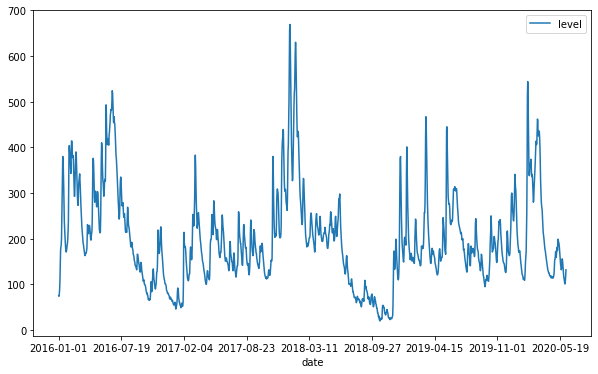

In [3]:
df.plot()

In [4]:
start_date, end_date = df.index[0], df.index[-1]
start_date, end_date

('2016-01-01', '2020-06-07')

### Rhine river coordinates

In order to to pick stations located near the Rhine river I marked 400+ coordinates of Rhine river. This was done by using the Google Maps API and automatically retrieving coordinates along the Rhine in Germany. The next step is to filter all stations by coordinates in 10km radius.

In [5]:
with open('Rhine.json') as json_file:
    rhine_coordinates_json = json.load(json_file)
rhine_coordinates = [[float(e) for e in element['Point']['coordinates'].split(',')[:2]] for element in rhine_coordinates_json['Document']['Placemark']]

rhine_coordinates = pd.DataFrame(data=rhine_coordinates, columns=['geoLaenge','geoBreite'])
rhine_coordinates = rhine_coordinates[['geoBreite', 'geoLaenge']]
rhine_coordinates

,geoBreite,geoLaenge
0,46.823321,9.407988
1,47.405785,9.652176
2,47.500503,9.670372
3,47.665850,9.179077
4,47.657525,8.860817
...,...,...
445,48.788607,8.066521
446,48.754213,7.973137
447,48.784083,8.030816
448,48.649077,7.845421


### Stations fetching

In [6]:
stations_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/KL_Tageswerte_Beschreibung_Stationen.txt'
stations = requests.get(stations_url).text
stations = stations.split('\r\n')
print(stations[0])

Stations_id von_datum bis_datum Stationshoehe geoBreite geoLaenge Stationsname Bundesland


In [7]:
stations_columns = stations[0].split(' ')
stations_columns

stations[2][0:10]

'00001 1937'

In [8]:
stations_array = []
#manuelle Kodierung des Endens der Indizes in der Station Liste (indexe passen mit Ende der jwlg. Information zsm.)
indexes = [0,6,15,35,43,53,61,102]
for station in stations[2:-1]:
    array = []
    for i, index  in enumerate(indexes):
        start = index
        end = indexes[i+1] if i < len(indexes) - 1 else len(station) - 1
        array.append(station[start:end].strip())
    #hänge hier eine Station an
    stations_array.append(array)

In [9]:
stations_df = pd.DataFrame(data=stations_array, columns=stations_columns)
stations_df['geoBreite'] = stations_df['geoBreite'].astype(float)
stations_df['geoLaenge'] = stations_df['geoLaenge'].astype(float)
stations_df

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,00001,19370101,19860630,478,47.8413,8.8493,Aach,Baden-Württemberg
1,00003,18910101,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
2,00011,19800901,20200930,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
3,00044,19690101,20210204,44,52.9336,8.2370,Großenkneten,Niedersachsen
4,00052,19690101,20011231,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
...,...,...,...,...,...,...,...,...
1325,15979,19480101,19790331,426,49.9311,7.5153,Sargenroth,Rheinland-Pfalz
1326,16085,19600701,19611231,8,53.5874,8.6011,Leherheide,Bremen
1327,19087,19570501,19951130,645,48.8049,13.5528,Freyung vorm Wald,Bayern
1328,19171,20200901,20210204,13,54.0038,9.8553,Hasenkrug-Hardebek,Schleswig-Holstein


### Distance calculation

To calculate the distance between stations and Google fed coordinates, we will use implementation of Haversine formula

In [10]:
def distance(first_coordinate, second_coordinate):
    # approximate radius of earth in km
    R = 6373.0 
    
    lat1 = np.radians(first_coordinate[0])
    lon1 = np.radians(first_coordinate[1])
    
    lat2 = np.radians(second_coordinate[0])
    lon2 = np.radians(second_coordinate[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance


In [11]:
#im Folgenden wird Gebrauch von der pandas bzw. numpy Funktionalität der vectorization gemacht; es wird für jede 
#Station die Distanz zu jedem einzelnen der Rheinkoordinaten berechnet
for row in rhine_coordinates.index:
    first_coordinate = stations_df['geoBreite'], stations_df['geoLaenge']
    second_coordinate = rhine_coordinates.at[row,'geoBreite'], rhine_coordinates.at[row,'geoLaenge']
    stations_df[row] = distance(first_coordinate,  second_coordinate)
stations_df

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,0,1,...,440,441,442,443,444,445,446,447,448,449
0,00001,19370101,19860630,478,47.8413,8.8493,Aach,Baden-Württemberg,120.807986,77.262235,...,151.165781,145.011511,136.337298,133.280446,130.417400,120.228961,120.473605,121.088172,116.626568,114.735057
1,00003,18910101,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,502.763193,456.219744,...,242.830636,247.365802,252.434983,253.489287,254.824329,263.153068,262.906899,262.212455,268.655699,271.659243
2,00011,19800901,20200930,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg,144.350308,105.686307,...,132.718741,126.301386,116.531303,112.556405,108.798202,96.647119,95.776806,97.127160,90.206484,87.842462
3,00044,19690101,20210204,44,52.9336,8.2370,Großenkneten,Niedersachsen,684.782870,623.035667,...,419.535566,426.018330,436.358582,441.150498,445.988867,461.201875,465.240819,461.776555,477.359378,482.027464
4,00052,19690101,20011231,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein,762.763588,696.978365,...,516.271660,522.729196,533.973496,539.743038,545.485989,562.015548,567.457906,563.162392,581.206419,586.205505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,15979,19480101,19790331,426,49.9311,7.5153,Sargenroth,Rheinland-Pfalz,372.857619,321.742184,...,105.401739,110.424500,116.890389,119.077979,121.666559,133.204845,135.043589,132.935868,144.595888,148.728635
1326,16085,19600701,19611231,8,53.5874,8.6011,Leherheide,Bremen,754.543547,691.569220,...,492.415135,498.927142,509.502036,514.509195,519.543299,535.064165,539.369502,535.744679,551.808206,556.545763
1327,19087,19570501,19951130,645,48.8049,13.5528,Freyung vorm Wald,Bayern,379.952367,328.813567,...,380.333914,380.529917,384.924097,389.446946,393.837787,401.900393,408.913037,404.535639,419.024817,421.720445
1328,19171,20200901,20210204,13,54.0038,9.8553,Hasenkrug-Hardebek,Schleswig-Holstein,799.308107,734.034739,...,548.134400,554.634494,565.734618,571.309027,576.870005,593.167885,598.295429,594.182250,611.701448,616.638783


### Stations sample

Select stations in 40km radius to the Rhine river

In [12]:
DISTANCE_THRESHOLD = 40
stations_near_rhine = (stations_df.iloc[:,8:] < DISTANCE_THRESHOLD).any(1)
stations_sample = stations_df[stations_near_rhine]
stations_sample

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,0,1,...,440,441,442,443,444,445,446,447,448,449
0,00001,19370101,19860630,478,47.8413,8.8493,Aach,Baden-Württemberg,120.807986,77.262235,...,151.165781,145.011511,136.337298,133.280446,130.417400,120.228961,120.473605,121.088172,116.626568,114.735057
2,00011,19800901,20200930,680,47.9737,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg,144.350308,105.686307,...,132.718741,126.301386,116.531303,112.556405,108.798202,96.647119,95.776806,97.127160,90.206484,87.842462
25,00150,19510101,20210204,215,49.7273,8.1164,Alzey,Rheinland-Pfalz,336.849525,281.865619,...,65.421550,71.532827,80.756717,84.933776,89.421674,104.473460,108.735056,105.097714,121.537382,126.403397
28,00161,19801201,20210204,75,50.4237,7.4202,Andernach,Rheinland-Pfalz,426.262758,373.187872,...,155.958513,161.594164,169.309637,172.199752,175.354454,187.741177,189.927188,187.608961,199.762218,203.924216
33,00174,19840301,19871231,250,49.1886,7.9766,Annweiler-Bindersbach,Rheinland-Pfalz,283.822422,233.859734,...,28.757554,29.556299,30.532697,30.874636,32.688311,44.972686,48.317411,45.168095,60.772106,65.642070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,15200,20130601,20210204,327,51.2531,7.2157,Wuppertal,Nordrhein-Westfalen,517.943240,462.883930,...,246.597779,252.558033,261.031169,264.370965,267.883084,280.782492,283.172067,280.734226,293.127266,297.286167
1321,15963,19540101,20041130,40,51.3258,6.5089,St. Tönis,Nordrhein-Westfalen,543.426698,491.778966,...,274.595862,280.066203,287.238920,289.647284,292.264255,303.323299,304.546752,302.869873,312.683559,316.350729
1323,15976,20200402,20210204,216,49.9529,8.2107,Ober-Olm/Bellem,Rheinland-Pfalz,359.147947,302.432666,...,88.638987,95.014883,104.977187,109.619244,114.456744,129.924420,134.435939,130.658523,147.423656,152.313475
1324,15978,20200402,20210204,316,49.5044,7.8618,Sembach,Rheinland-Pfalz,319.499466,268.182831,...,52.930390,57.406430,63.311377,65.516877,68.367106,80.998825,83.835665,81.059039,95.144863,99.741815


Somit erreichen wir schon eine erhebliche Reduktion unserer initialen Stationen (1329) auf 258.

## Additional dataset

DATA SET DESCRIPTION: 
Recent daily station observations (temperature, pressure, precipitation, sunshineduration, etc.) for Germany.

#### Fetching recent data

In [13]:
recent_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/'
resp = requests.get(recent_url).text
zips = [e[:e.find('zip') + 3].split('_') for e in resp.split('\r\n<a href="') if 'zip' in e]
print('Initial stations number: ', len(zips))
#müssen rausfiltern, ob wir die jeweilige zip datei überhaupt runterladen wollen, hier der zweite index in der
#zerlegung der html antwort
zips = [e for e in zips if e[2] in stations_sample['Stations_id'].values] #apply filter
print('Filtered stations number: ', len(zips))
recent_stations_ids = [e[2] for e in zips]

Initial stations number:  581
Filtered stations number:  94


In [14]:
#hier kreieren wir lediglich die ordner, worin die Daten erstmal abgespeichert werden sollen.
#die hierfür verwendeten regex-ausdrücke sind datenspezifisch und deshalb für das weitere verständnis unerheblich.
if not os.path.exists('./Dataset/'):
    os.mkdir('./Dataset/')

for file in zips:
    file_name = '_'.join(file)
    zip_path = tf.keras.utils.get_file(
        origin=recent_url + file_name,
        fname=file_name,
        extract=True,
        cache_dir='./Dataset/',
        cache_subdir=file[2])

#### Fetching historical data

In [15]:
historical_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/'
resp = requests.get(historical_url).text
h_zips = [e[:e.find('zip') + 3].split('_') for e in resp.split('\r\n<a href="') if 'zip' in e]
h_zips = [e for e in h_zips if len(e) > 5 and e[4] == '20191231' and e[2] in recent_stations_ids and int(e[3][:4]) < 2016]
print('Historical data stations number', len(h_zips))
historical_stations_ids = [e[2] for e in h_zips]

Historical data stations number 86


In [16]:
for file in h_zips:
    file_name = '_'.join(file)
    zip_path = tf.keras.utils.get_file(
        origin=historical_url + file_name,
        fname=file_name,
        extract=True,
        cache_dir='./Dataset/',
        cache_subdir=file[2])

Now we have two datasets for each station. In generate_dataset function we take hisorical and more recent data, merge them together and filter our all stations, that has NA values (-999) for the RSK variable. Combining all stations RSK alltogether we can get precipitation data for our basic dataset.

In [ ]:
print(historical_stations_ids)

In [ ]:
dfs = []
lag = 0
for station in historical_stations_ids:
        files_list = glob.glob(f"./Dataset/{station}/produkt*.txt")

        #geht die txt (bzw. csv) durch und schmeißt alle beobachtungen raus, welche vor dem startdatum 2016 angefangen
        #haben und danach waren
        #DISCLAIMER: historische Daten werden in der fileendung immer mit dem 20191231 markiert, die die NICHT das
        #in der Endung haben sind aktuell.
        
        historical_filename = [file for file in files_list if '20191231' in file][0]
        hisotrical_data = pd.read_csv(historical_filename, sep=';')
        hisotrical_data['MESS_DATUM'] = hisotrical_data['MESS_DATUM'].astype(str).apply(lambda x:f'{x[:4]}-{x[4:6]}-{x[6:]}')
        hisotrical_data.set_index('MESS_DATUM', inplace=True)
        hisotrical_data = hisotrical_data.shift(periods=lag).loc[start_date:]
        hisotrical_data_end_date = hisotrical_data.index[-1]

        recent_filename = [file for file in files_list if '20191231' not in file][0]
        recent_data = pd.read_csv(recent_filename, sep=';')
        recent_data['MESS_DATUM'] = recent_data['MESS_DATUM'].astype(str).apply(lambda x:f'{x[:4]}-{x[4:6]}-{x[6:]}')
        recent_data.set_index('MESS_DATUM', inplace=True)
        recent_data = recent_data.shift(periods=lag).loc[hisotrical_data_end_date:end_date].iloc[1:]

        
        merged = pd.concat([hisotrical_data, recent_data])
        merged.columns = [col.strip() for col in merged.columns] #rein der schönheit halber
        if (merged['RSK'] == -999).sum() != merged.shape[0]: #schmeißt alle raus, die nur nans haben
            merged[station] = merged['RSK']
            #print(merged[station])
            if pd.isna(merged[station]).any():
                display(merged[station])
            dfs.append(merged[station])


In [ ]:
precipitation_data = pd.concat(dfs, axis=1)

In [20]:
def generate_dataset(lag=0):
    dfs = []
    for station in historical_stations_ids:
        files_list = glob.glob(f"./Dataset/{station}/produkt*.txt")

        #geht die txt (bzw. csv) durch und schmeißt alle beobachtungen raus, welche vor dem startdatum 2016 angefangen
        #haben und danach waren
        #DISCLAIMER: historische Daten werden in der fileendung immer mit dem 20191231 markiert, die die NICHT das
        #in der Endung haben sind aktuell
        
        historical_filename = [file for file in files_list if '20191231' in file][0]
        hisotrical_data = pd.read_csv(historical_filename, sep=';')
        hisotrical_data['MESS_DATUM'] = hisotrical_data['MESS_DATUM'].astype(str).apply(lambda x:f'{x[:4]}-{x[4:6]}-{x[6:]}')
        hisotrical_data.set_index('MESS_DATUM', inplace=True)
        hisotrical_data = hisotrical_data.shift(periods=lag).loc[start_date:]
        hisotrical_data_end_date = hisotrical_data.index[-1]

        recent_filename = [file for file in files_list if '20191231' not in file][0]
        recent_data = pd.read_csv(recent_filename, sep=';')
        recent_data['MESS_DATUM'] = recent_data['MESS_DATUM'].astype(str).apply(lambda x:f'{x[:4]}-{x[4:6]}-{x[6:]}')
        recent_data.set_index('MESS_DATUM', inplace=True)
        recent_data = recent_data.shift(periods=lag).loc[hisotrical_data_end_date:end_date].iloc[1:]

        merged = pd.concat([hisotrical_data, recent_data])
        merged.columns = [col.strip() for col in merged.columns]
        if (merged['RSK'] == -999).sum() != merged.shape[0]:
            merged[station] = merged['RSK']
            if pd.isna(merged[station]).any():
                display(merged[station])
            dfs.append(merged[station])
    precipitation_data = pd.concat(dfs, axis=1)
    dataset_features = pd.concat([df, precipitation_data], axis=1)
    columns_with_na_values = dataset_features.loc[:,pd.isna(dataset_features).any()].columns
    dataset_features.drop(columns_with_na_values,axis=1,inplace=True)
    return dataset_features
    #dataset_features.fillna(0, inplace=True)

In [21]:
dataset_no_shift = generate_dataset()
dataset_no_shift

,level,00150,00161,00257,00259,00377,00535,00603,00617,00757,...,05731,05871,05906,06258,06263,06344,07341,13670,13674,13700
2016-01-01,75,0.4,0.0,0.2,0.4,0.1,0.0,0.0,0.0,0.8,...,1.3,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0
2016-01-02,74,5.9,2.3,3.6,7.9,2.3,2.7,4.9,1.4,6.9,...,8.1,2.5,7.5,14.3,10.0,6.8,10.4,2.9,8.4,1.6
2016-01-03,80,4.4,4.9,12.4,16.9,9.0,5.5,5.8,10.1,6.3,...,14.9,3.5,4.3,6.8,10.1,2.5,3.5,6.1,8.1,2.8
2016-01-04,89,0.6,0.3,3.9,5.6,5.6,1.1,1.1,7.0,3.7,...,9.6,4.3,4.3,1.8,3.4,1.5,5.0,4.5,6.6,5.7
2016-01-05,108,5.1,0.2,6.7,2.4,5.6,2.4,7.9,1.4,3.1,...,6.5,2.0,6.4,1.6,4.1,1.8,3.2,0.7,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-03,103,3.8,7.3,1.7,4.1,2.1,9.5,4.3,0.0,4.8,...,5.1,10.1,4.9,1.1,0.9,4.9,0.5,0.0,0.3,2.6
2020-06-04,101,13.0,2.7,27.5,12.7,5.9,9.0,2.8,8.7,14.1,...,13.5,9.6,22.3,10.5,16.2,3.7,11.1,9.2,15.2,10.4
2020-06-05,107,8.3,3.4,22.8,2.6,10.2,7.8,0.0,16.6,8.1,...,4.8,4.7,7.8,0.9,0.2,4.2,5.1,14.7,17.7,11.3
2020-06-06,117,0.5,5.1,17.3,8.6,2.0,2.0,0.0,0.7,15.3,...,15.6,3.2,1.0,6.3,13.5,1.1,3.0,1.7,3.0,4.1


In [22]:
dataset_shift_1 = generate_dataset(1)
dataset_shift_2 = generate_dataset(2)

dataset_shift_1

,level,00150,00161,00257,00259,00377,00535,00603,00617,00757,...,05731,05871,05906,06258,06263,06344,07341,13670,13674,13700
2016-01-01,75,1.0,0.8,3.0,0.6,1.6,1.6,2.9,1.8,3.5,...,1.8,1.7,1.0,4.6,2.5,3.0,1.4,3.1,2.3,1.8
2016-01-02,74,0.4,0.0,0.2,0.4,0.1,0.0,0.0,0.0,0.8,...,1.3,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0
2016-01-03,80,5.9,2.3,3.6,7.9,2.3,2.7,4.9,1.4,6.9,...,8.1,2.5,7.5,14.3,10.0,6.8,10.4,2.9,8.4,1.6
2016-01-04,89,4.4,4.9,12.4,16.9,9.0,5.5,5.8,10.1,6.3,...,14.9,3.5,4.3,6.8,10.1,2.5,3.5,6.1,8.1,2.8
2016-01-05,108,0.6,0.3,3.9,5.6,5.6,1.1,1.1,7.0,3.7,...,9.6,4.3,4.3,1.8,3.4,1.5,5.0,4.5,6.6,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-03,103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-04,101,3.8,7.3,1.7,4.1,2.1,9.5,4.3,0.0,4.8,...,5.1,10.1,4.9,1.1,0.9,4.9,0.5,0.0,0.3,2.6
2020-06-05,107,13.0,2.7,27.5,12.7,5.9,9.0,2.8,8.7,14.1,...,13.5,9.6,22.3,10.5,16.2,3.7,11.1,9.2,15.2,10.4
2020-06-06,117,8.3,3.4,22.8,2.6,10.2,7.8,0.0,16.6,8.1,...,4.8,4.7,7.8,0.9,0.2,4.2,5.1,14.7,17.7,11.3


In [23]:
print('Stations with RSK data', dataset_no_shift.shape[1] - 1)

Stations with RSK data 66


### Model

#### Recurrent neural network


A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this project, we will use a specialized RNN layer called Long Short Term Memory (LSTM). In order to feed the data to the RNN we need to resize the dataset.

The function below returns the windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [24]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. We will predict data for 10 days ahead.

In [25]:
log = True
dataset = dataset_no_shift.copy()
if log:
    dataset[dataset <= 0] = 0.1
    dataset = np.log(dataset)
    #display(dataset)
    
dataset = dataset.values #entfernt den index
print(dataset.shape)

(1620, 67)


In [26]:
log = True
dataset = dataset_no_shift.copy()
if log:
    dataset[dataset <= 0] = 0.1
    dataset = np.log(dataset)
    display(dataset)
    
dataset = dataset.values
past_history = 20
future_target = 10
TRAIN_SPLIT = int(dataset.shape[0] * 0.9)

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, None, past_history, future_target)

print(x_train_multi.shape, y_train_multi.shape) 

BATCH_SIZE = 500
BUFFER_SIZE = 1000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

,level,00150,00161,00257,00259,00377,00535,00603,00617,00757,...,05731,05871,05906,06258,06263,06344,07341,13670,13674,13700
2016-01-01,4.317488,-0.916291,-2.302585,-1.609438,-0.916291,-2.302585,-2.302585,-2.302585,-2.302585,-0.223144,...,0.262364,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
2016-01-02,4.304065,1.774952,0.832909,1.280934,2.066863,0.832909,0.993252,1.589235,0.336472,1.931521,...,2.091864,0.916291,2.014903,2.660260,2.302585,1.916923,2.341806,1.064711,2.128232,0.470004
2016-01-03,4.382027,1.481605,1.589235,2.517696,2.827314,2.197225,1.704748,1.757858,2.312535,1.840550,...,2.701361,1.252763,1.458615,1.916923,2.312535,0.916291,1.252763,1.808289,2.091864,1.029619
2016-01-04,4.488636,-0.510826,-1.203973,1.360977,1.722767,1.722767,0.095310,0.095310,1.945910,1.308333,...,2.261763,1.458615,1.458615,0.587787,1.223775,0.405465,1.609438,1.504077,1.887070,1.740466
2016-01-05,4.682131,1.629241,-1.609438,1.902108,0.875469,1.722767,0.875469,2.066863,0.336472,1.131402,...,1.871802,0.693147,1.856298,0.470004,1.410987,0.587787,1.163151,-0.356675,2.639057,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-03,4.634729,1.335001,1.987874,0.530628,1.410987,0.741937,2.251292,1.458615,-2.302585,1.568616,...,1.629241,2.312535,1.589235,0.095310,-0.105361,1.589235,-0.693147,-2.302585,-1.203973,0.955511
2020-06-04,4.615121,2.564949,0.993252,3.314186,2.541602,1.774952,2.197225,1.029619,2.163323,2.646175,...,2.602690,2.261763,3.104587,2.351375,2.785011,1.308333,2.406945,2.219203,2.721295,2.341806
2020-06-05,4.672829,2.116256,1.223775,3.126761,0.955511,2.322388,2.054124,-2.302585,2.809403,2.091864,...,1.568616,1.547563,2.054124,-0.105361,-1.609438,1.435085,1.629241,2.687847,2.873565,2.424803
2020-06-06,4.762174,-0.693147,1.629241,2.850707,2.151762,0.693147,0.693147,-2.302585,-0.356675,2.727853,...,2.747271,1.163151,0.000000,1.840550,2.602690,0.095310,1.098612,0.530628,1.098612,1.410987


(1438, 20, 67) (1438, 10)


Let's now use tf.data to shuffle, batch, and cache the dataset.

Plotting a sample data-point.

In [27]:
def multi_step_plot(history, true_future, prediction):
    if log:
        history = np.exp(history)
        true_future = np.exp(true_future)


    plt.figure(figsize=(12, 6))
    num_in = list(range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        prediction = np.exp(prediction)
        plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

Plotting a sample data-point.

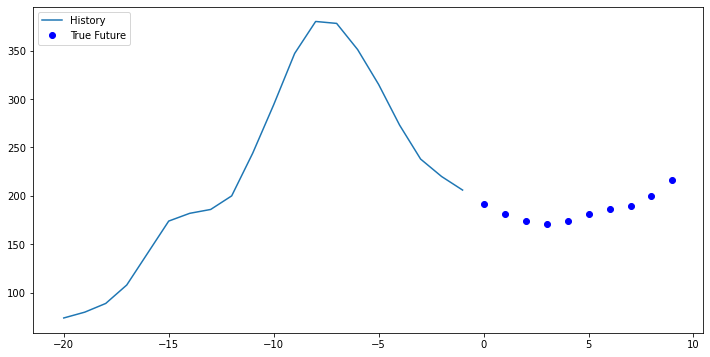

In [28]:
multi_step_plot(x_train_multi[1], y_train_multi[1], np.array([0]))


We tried different number of neurons for the following network, 32 and 16 are the most suitable ones. Greater number or neurons has tendecy to overfitting.

In [39]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(10))
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")



In [40]:
EVALUATION_INTERVAL = 20
EPOCHS = 30

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=30)

Epoch 1/30
20/20 [==============================] - 1s 70ms/step - loss: 24.7598 - val_loss: 23.5388
Epoch 2/30
20/20 [==============================] - 1s 49ms/step - loss: 15.9995 - val_loss: 11.5671
Epoch 3/30
20/20 [==============================] - 1s 49ms/step - loss: 6.0928 - val_loss: 3.3786
Epoch 4/30
20/20 [==============================] - 1s 48ms/step - loss: 1.1407 - val_loss: 1.0882
Epoch 5/30
20/20 [==============================] - 1s 50ms/step - loss: 0.4348 - val_loss: 0.6297
Epoch 6/30
20/20 [==============================] - 1s 48ms/step - loss: 0.2781 - val_loss: 0.4510
Epoch 7/30
20/20 [==============================] - 1s 49ms/step - loss: 0.2147 - val_loss: 0.4179
Epoch 8/30
20/20 [==============================] - 1s 49ms/step - loss: 0.1783 - val_loss: 0.3645
Epoch 9/30
20/20 [==============================] - 1s 48ms/step - loss: 0.1539 - val_loss: 0.3314
Epoch 10/30
20/20 [==============================] - 1s 49ms/step - loss: 0.1363 - val_loss: 0.2927
Epoch

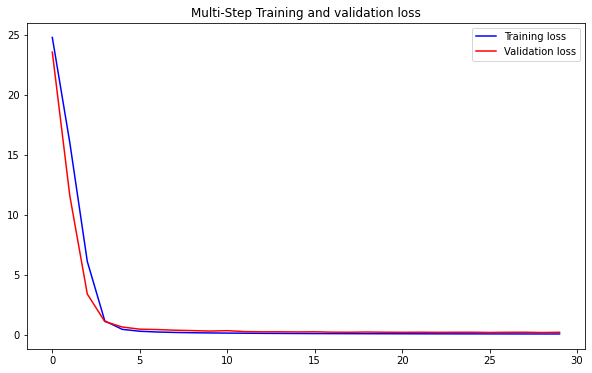

In [41]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

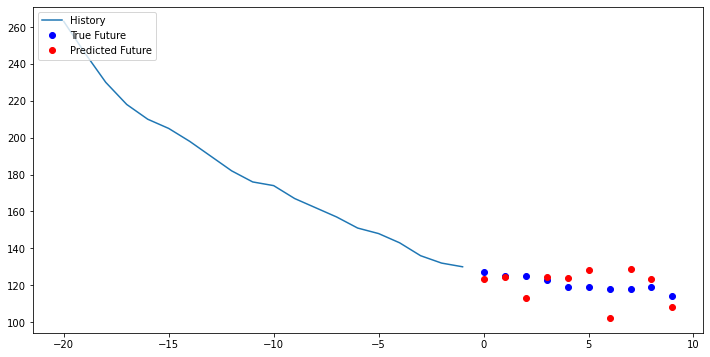

In [42]:
index=-47
multi_step_plot(x_val_multi[index], y_val_multi[index],  multi_step_model.predict(x_val_multi[index-1:index])[0])

In [43]:
x_full, y_full = multivariate_data(dataset, dataset[:, 1],
                                             0, None, past_history,
                                             future_target)
forecasts = multi_step_model.predict(x_full[-1:])[0]
if log:
    forecasts = np.exp(forecasts)

In [44]:
time_index = ['2020-06-08', '2020-06-09'] + ['2020-06-' + str(i) for i in range(10,18)]
time_index

['2020-06-08',
 '2020-06-09',
 '2020-06-10',
 '2020-06-11',
 '2020-06-12',
 '2020-06-13',
 '2020-06-14',
 '2020-06-15',
 '2020-06-16',
 '2020-06-17']

In [45]:
predictions = pd.DataFrame(data=forecasts, index=time_index, columns=['Forecasts'])
predictions

,Forecasts
2020-06-08,132.549759
2020-06-09,127.396751
2020-06-10,118.665489
2020-06-11,122.375198
2020-06-12,128.689163
2020-06-13,120.729950
2020-06-14,108.064194
2020-06-15,137.830338
2020-06-16,116.712555
2020-06-17,124.005730
